# U-Net on Pets Dataset


In [1]:
import matplotlib.pylab as plt
import numpy as np
import re

import tensorflow as tf
from tensorflow.keras import (
    Sequential,
    Model,
    applications,
    utils,
    layers,
    callbacks,
    losses,
    preprocessing,
)
import tensorflow_datasets as tfds


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 512
BUFFER_SIZE = 10000
OUTPUT_CHANNELS = 3

BASE_MODEL = applications.MobileNetV2(input_shape=(128, 128, 3), include_top=True)

LAYER_NAMES = [
    "block_1_expand_relu",  # 64x64
    "block_3_expand_relu",  # 32x32
    "block_6_expand_relu",  # 16x16
    "block_13_expand_relu",  # 8x8
    "block_16_project",  # 4x4
]


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


## Load the Dataset


In [4]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)


In [5]:
def read_and_preprocess(data):
    input_image = tf.image.resize(data["image"], (128, 128))
    input_mask = tf.image.resize(data["segmentation_mask"], (128, 128))

    input_image = tf.image.convert_image_dtype(input_image, tf.float32)

    return input_image, input_mask


In [6]:
train = dataset["train"].map(read_and_preprocess).shuffle(buffer_size=10000)
test = dataset["test"].map(read_and_preprocess)


## Display some example images with labels


2022-03-31 20:59:00.954601: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


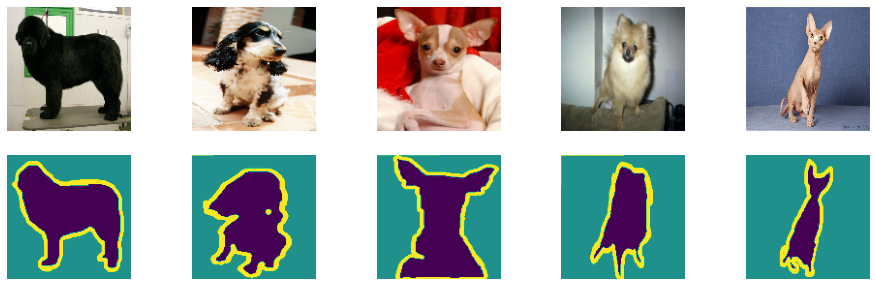

In [7]:
f, ax = plt.subplots(2, 5, figsize=(16, 5))
for idx, (img, mask) in enumerate(train.take(5)):
    ax[0, idx].imshow(preprocessing.image.array_to_img(img))
    ax[0, idx].axis("off")

    mask = tf.reshape(mask, [128, 128])
    ax[1, idx].imshow(mask.numpy())
    ax[1, idx].axis("off")


## Modified U-Net


In [8]:
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    return img, mask


train_dataset = (
    train.cache().map(augment).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)


In [9]:
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


In [10]:
base_model_outputs = [BASE_MODEL.get_layer(layer).output for layer in LAYER_NAMES]

down_stack = Model(
    inputs=BASE_MODEL.input, outputs=base_model_outputs, name="pretrained_mobilenet"
)

down_stack.trainable = False


In [11]:
def upsample(filters, size, name):
    return Sequential(
        [
            layers.Conv2DTranspose(filters, size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name=name,
    )


up_stack = [
    upsample(512, 3, "upsample_4x4_to_8x8"),
    upsample(256, 3, "upsample_8x8_to_16x16"),
    upsample(128, 3, "upsample_16x16_to_32x32"),
    upsample(64, 3, "upsample_32x32_to_64x64"),
]


In [12]:
def unet_model(output_channels):
    inputs = layers.Input(shape=[128, 128, 3], name="input_image")

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for idx, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        concat = layers.Concatenate(name=f"expand_{idx}")
        x = concat([x, skip])

    # This is the last layer of the model
    last = layers.Conv2DTranspose(output_channels, 3, strides=2, padding="same")

    x = last(x)

    return Model(inputs=inputs, outputs=x)


In [13]:
model = unet_model(OUTPUT_CHANNELS)
utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Train the model

In [14]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
# Assign to the pixel the label with the highest probability
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [16]:
# Display helper function
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


def show_predictions(dataset, num):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2022-03-31 20:59:04.627890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


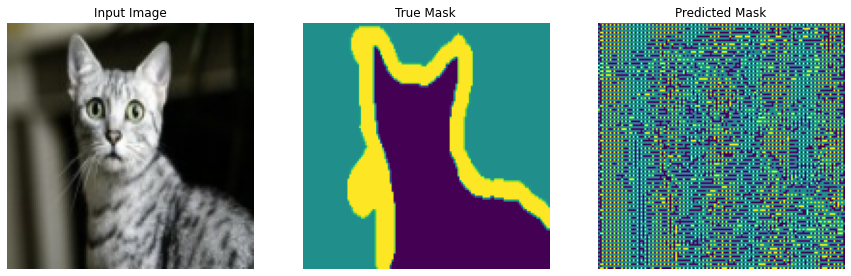

In [17]:
show_predictions(train.batch(1), 1)

In [18]:
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            show_predictions(train.batch(1), 1)
            print(f'\nSample predicition after epoch {epoch + 1}\n')

Epoch 1/900


2022-03-31 20:59:07.267224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


7/7 [==============================] - ETA: 0s - loss: 1.0599 - accuracy: 0.4342

2022-03-31 20:59:22.533333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


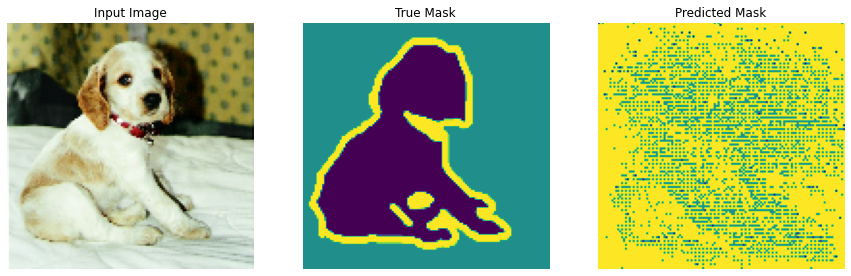


Sample predicition after epoch 1

7/7 [==============================] - 20s 2s/step - loss: 1.0599 - accuracy: 0.4342 - val_loss: 0.7536 - val_accuracy: 0.5492
Epoch 2/900
7/7 [==============================] - 13s 2s/step - loss: 0.6038 - accuracy: 0.6155 - val_loss: 0.7201 - val_accuracy: 0.5348
Epoch 3/900
7/7 [==============================] - 12s 2s/step - loss: 0.4736 - accuracy: 0.6614 - val_loss: 1.3999 - val_accuracy: 0.4547
Epoch 4/900
7/7 [==============================] - 12s 2s/step - loss: 0.4177 - accuracy: 0.7004 - val_loss: 1.1193 - val_accuracy: 0.4836
Epoch 5/900
7/7 [==============================] - 12s 2s/step - loss: 0.3911 - accuracy: 0.7136 - val_loss: 1.2069 - val_accuracy: 0.4638
Epoch 6/900
7/7 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.7228

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


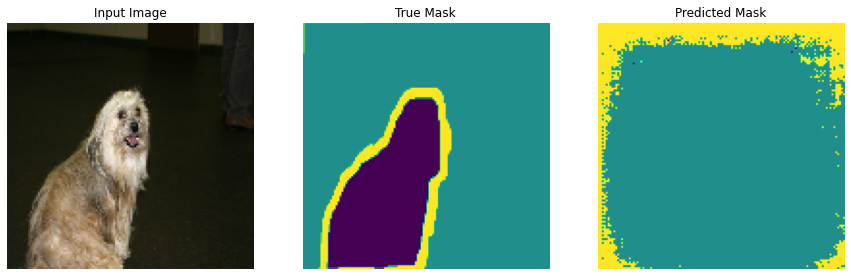


Sample predicition after epoch 6

7/7 [==============================] - 13s 2s/step - loss: 0.3837 - accuracy: 0.7228 - val_loss: 1.1007 - val_accuracy: 0.4810
Epoch 7/900
7/7 [==============================] - 12s 2s/step - loss: 0.3733 - accuracy: 0.7293 - val_loss: 1.1210 - val_accuracy: 0.4743
Epoch 8/900
7/7 [==============================] - 12s 2s/step - loss: 0.3703 - accuracy: 0.7329 - val_loss: 0.8626 - val_accuracy: 0.5306
Epoch 9/900
7/7 [==============================] - 13s 2s/step - loss: 0.3644 - accuracy: 0.7366 - val_loss: 0.5624 - val_accuracy: 0.6188
Epoch 10/900
7/7 [==============================] - 12s 2s/step - loss: 0.3616 - accuracy: 0.7396 - val_loss: 0.5291 - val_accuracy: 0.6298
Epoch 11/900
7/7 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.7417

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


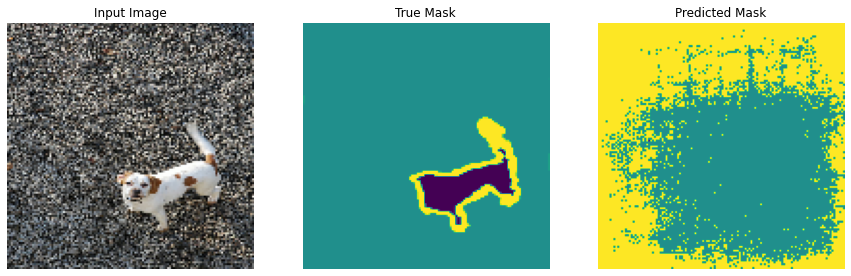


Sample predicition after epoch 11

7/7 [==============================] - 14s 2s/step - loss: 0.3561 - accuracy: 0.7417 - val_loss: 0.5406 - val_accuracy: 0.6229
Epoch 12/900
7/7 [==============================] - 12s 2s/step - loss: 0.3541 - accuracy: 0.7433 - val_loss: 0.4171 - val_accuracy: 0.6889
Epoch 13/900
7/7 [==============================] - 12s 2s/step - loss: 0.3492 - accuracy: 0.7465 - val_loss: 0.3772 - val_accuracy: 0.7213
Epoch 14/900
7/7 [==============================] - 12s 2s/step - loss: 0.3475 - accuracy: 0.7490 - val_loss: 0.3578 - val_accuracy: 0.7335
Epoch 15/900
7/7 [==============================] - 12s 2s/step - loss: 0.3469 - accuracy: 0.7491 - val_loss: 0.3578 - val_accuracy: 0.7354
Epoch 16/900
7/7 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.7508

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


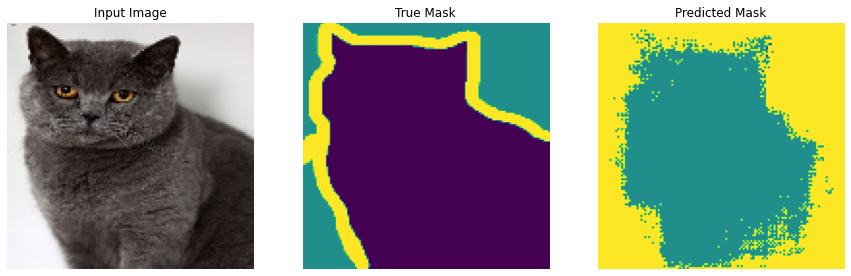


Sample predicition after epoch 16

7/7 [==============================] - 14s 2s/step - loss: 0.3444 - accuracy: 0.7508 - val_loss: 0.3539 - val_accuracy: 0.7334
Epoch 17/900
7/7 [==============================] - 14s 2s/step - loss: 0.3454 - accuracy: 0.7499 - val_loss: 0.3532 - val_accuracy: 0.7371
Epoch 18/900
7/7 [==============================] - 12s 2s/step - loss: 0.3411 - accuracy: 0.7516 - val_loss: 0.3588 - val_accuracy: 0.7321
Epoch 19/900
7/7 [==============================] - 12s 2s/step - loss: 0.3401 - accuracy: 0.7515 - val_loss: 0.3563 - val_accuracy: 0.7341
Epoch 20/900
7/7 [==============================] - 12s 2s/step - loss: 0.3388 - accuracy: 0.7530 - val_loss: 0.3479 - val_accuracy: 0.7381
Epoch 21/900
7/7 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.7539

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


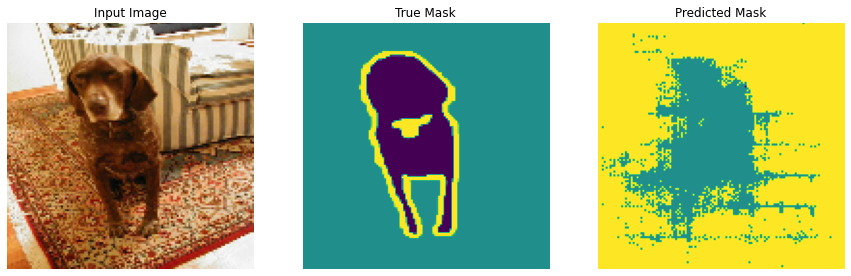


Sample predicition after epoch 21

7/7 [==============================] - 14s 2s/step - loss: 0.3359 - accuracy: 0.7539 - val_loss: 0.3583 - val_accuracy: 0.7324
Epoch 22/900
7/7 [==============================] - 12s 2s/step - loss: 0.3330 - accuracy: 0.7560 - val_loss: 0.3545 - val_accuracy: 0.7325
Epoch 23/900
7/7 [==============================] - 12s 2s/step - loss: 0.3354 - accuracy: 0.7549 - val_loss: 0.3567 - val_accuracy: 0.7340
Epoch 24/900
7/7 [==============================] - 13s 2s/step - loss: 0.3330 - accuracy: 0.7562 - val_loss: 0.3776 - val_accuracy: 0.7114
Epoch 25/900
7/7 [==============================] - 14s 2s/step - loss: 0.3314 - accuracy: 0.7571 - val_loss: 0.3846 - val_accuracy: 0.7053
Epoch 26/900
7/7 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.7572

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


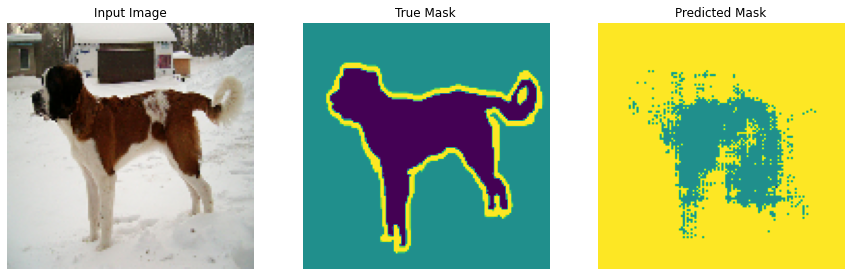


Sample predicition after epoch 26

7/7 [==============================] - 14s 2s/step - loss: 0.3325 - accuracy: 0.7572 - val_loss: 0.3584 - val_accuracy: 0.7255
Epoch 27/900
7/7 [==============================] - 13s 2s/step - loss: 0.3299 - accuracy: 0.7584 - val_loss: 0.3519 - val_accuracy: 0.7344
Epoch 28/900
7/7 [==============================] - 13s 2s/step - loss: 0.3342 - accuracy: 0.7557 - val_loss: 0.3732 - val_accuracy: 0.7145
Epoch 29/900
7/7 [==============================] - 12s 2s/step - loss: 0.3351 - accuracy: 0.7543 - val_loss: 0.3748 - val_accuracy: 0.7135
Epoch 30/900
7/7 [==============================] - 12s 2s/step - loss: 0.3301 - accuracy: 0.7575 - val_loss: 0.3716 - val_accuracy: 0.7161
Epoch 31/900
7/7 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.7563

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


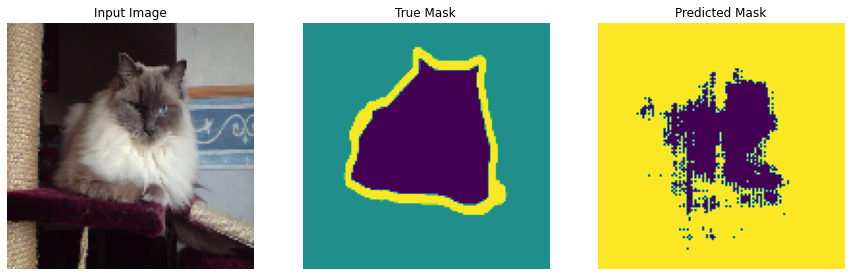


Sample predicition after epoch 31

7/7 [==============================] - 13s 2s/step - loss: 0.3326 - accuracy: 0.7563 - val_loss: 0.3853 - val_accuracy: 0.7062
Epoch 32/900
7/7 [==============================] - 12s 2s/step - loss: 0.3292 - accuracy: 0.7577 - val_loss: 0.3659 - val_accuracy: 0.7188
Epoch 33/900
7/7 [==============================] - 13s 2s/step - loss: 0.3278 - accuracy: 0.7586 - val_loss: 0.3477 - val_accuracy: 0.7330
Epoch 34/900
7/7 [==============================] - 12s 2s/step - loss: 0.3279 - accuracy: 0.7583 - val_loss: 0.3546 - val_accuracy: 0.7263
Epoch 35/900
7/7 [==============================] - 12s 2s/step - loss: 0.3268 - accuracy: 0.7594 - val_loss: 0.3586 - val_accuracy: 0.7231
Epoch 36/900
7/7 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.7591

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


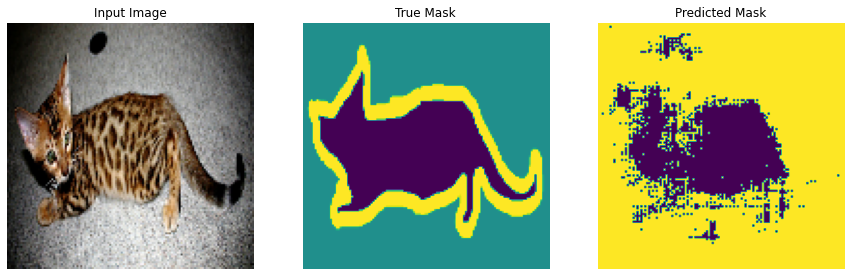


Sample predicition after epoch 36

7/7 [==============================] - 14s 2s/step - loss: 0.3279 - accuracy: 0.7591 - val_loss: 0.3778 - val_accuracy: 0.7093
Epoch 37/900
7/7 [==============================] - 12s 2s/step - loss: 0.3228 - accuracy: 0.7615 - val_loss: 0.3487 - val_accuracy: 0.7302
Epoch 38/900
7/7 [==============================] - 12s 2s/step - loss: 0.3281 - accuracy: 0.7605 - val_loss: 0.3459 - val_accuracy: 0.7325
Epoch 39/900
7/7 [==============================] - 12s 2s/step - loss: 0.3268 - accuracy: 0.7605 - val_loss: 0.3818 - val_accuracy: 0.7084
Epoch 40/900
7/7 [==============================] - 12s 2s/step - loss: 0.3256 - accuracy: 0.7612 - val_loss: 0.3812 - val_accuracy: 0.7088
Epoch 41/900
7/7 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.7606

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


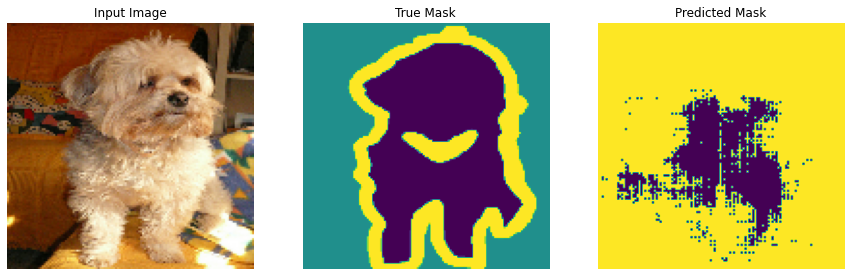


Sample predicition after epoch 41

7/7 [==============================] - 15s 2s/step - loss: 0.3265 - accuracy: 0.7606 - val_loss: 0.3925 - val_accuracy: 0.7015
Epoch 42/900
7/7 [==============================] - 12s 2s/step - loss: 0.3284 - accuracy: 0.7602 - val_loss: 0.3592 - val_accuracy: 0.7229
Epoch 43/900
7/7 [==============================] - 12s 2s/step - loss: 0.3276 - accuracy: 0.7593 - val_loss: 0.3718 - val_accuracy: 0.7146
Epoch 44/900
7/7 [==============================] - 12s 2s/step - loss: 0.3269 - accuracy: 0.7606 - val_loss: 0.3568 - val_accuracy: 0.7266
Epoch 45/900
7/7 [==============================] - 12s 2s/step - loss: 0.3251 - accuracy: 0.7604 - val_loss: 0.3726 - val_accuracy: 0.7157
Epoch 46/900
7/7 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.7586

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


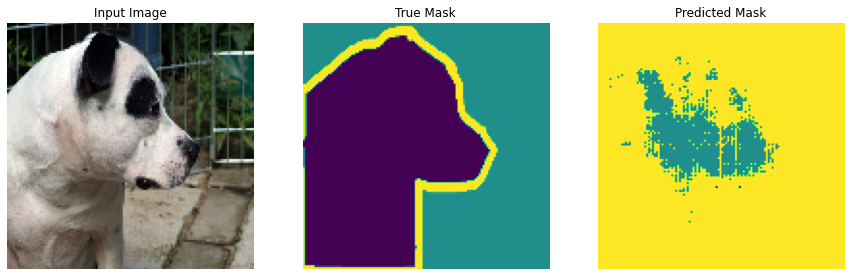


Sample predicition after epoch 46

7/7 [==============================] - 13s 2s/step - loss: 0.3275 - accuracy: 0.7586 - val_loss: 0.4219 - val_accuracy: 0.6899
Epoch 47/900
7/7 [==============================] - 12s 2s/step - loss: 0.3214 - accuracy: 0.7623 - val_loss: 0.4167 - val_accuracy: 0.6925
Epoch 48/900
7/7 [==============================] - 12s 2s/step - loss: 0.3277 - accuracy: 0.7602 - val_loss: 0.3712 - val_accuracy: 0.7164
Epoch 49/900
7/7 [==============================] - 13s 2s/step - loss: 0.3244 - accuracy: 0.7617 - val_loss: 0.3835 - val_accuracy: 0.7098
Epoch 50/900
7/7 [==============================] - 12s 2s/step - loss: 0.3248 - accuracy: 0.7613 - val_loss: 0.4173 - val_accuracy: 0.6900
Epoch 51/900
7/7 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.7604

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


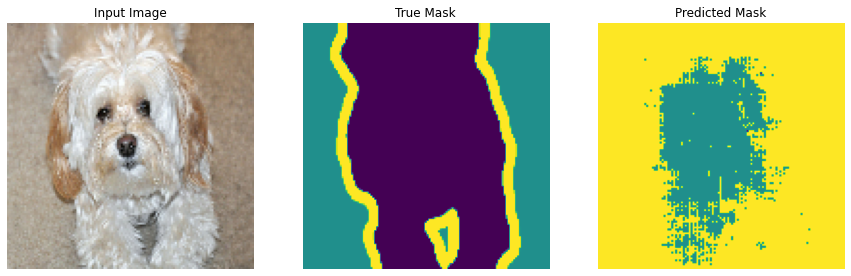


Sample predicition after epoch 51

7/7 [==============================] - 13s 2s/step - loss: 0.3285 - accuracy: 0.7604 - val_loss: 0.3866 - val_accuracy: 0.7093
Epoch 52/900
7/7 [==============================] - 12s 2s/step - loss: 0.3238 - accuracy: 0.7628 - val_loss: 0.4013 - val_accuracy: 0.7022
Epoch 53/900
7/7 [==============================] - 12s 2s/step - loss: 0.3308 - accuracy: 0.7598 - val_loss: 0.3851 - val_accuracy: 0.7090


In [19]:
EPOCHS = 900
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

early_stopping_cb = callbacks.EarlyStopping(patience=15, restore_best_weights=True)

model_history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    validation_data = test_dataset,
    callbacks = [DisplayCallback(), early_stopping_cb]
)

ValueError: x and y must have same first dimension, but have shapes (900,) and (53,)

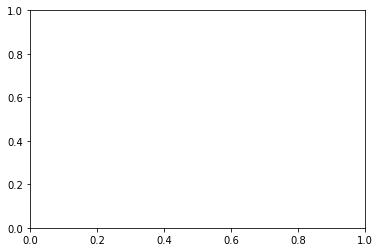

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()